In [1]:
import numpy as np
import subprocess
import os
import glob
import yaml
import xarray as xr
import math
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import osprey_io as io
import osprey_means as osm
import osprey_actions as osa

In [2]:
#rdata = osa.forecast_T_local_fit('lf00', 21, 10, 10, True, True)

In [2]:
#
expname='lf01'
leg=301
yearspan=5
yearleap=10
#
endyear = 1990+int(leg)-2
startyear = endyear - yearspan
xf = endyear+yearleap
data = io.readmf_T(expname, startyear, endyear)
x = osm.dateDecimal(data['time'].values.flatten())
ds = data['to'].isel(time=0)
ds_flat = ds.values.flatten()
to_flat = data['to'].values.flatten()
to_reshaped = to_flat.reshape(len(x),-1)
indices = ~np.isnan(to_reshaped)
indices_flat = ~np.isnan(to_flat)
to_valid = to_flat[indices_flat]
size_valid = to_valid.shape[0]/len(x)
to_wonan = np.zeros((len(x), int(size_valid)))
to_wonan = to_reshaped[:, indices[0]]

In [3]:
to_pred = []
model = LinearRegression()
for i in range(to_wonan.shape[1]):
    x_row = np.array(x).reshape(len(x),-1)
    y_row = to_wonan[:, i].reshape(len(x),-1)
    model.fit(x_row, y_row)
    mp = model.coef_[0][0]
    qp = model.intercept_[0]
    yf = model.predict([[xf]])
    to_pred.append(yf[0][0])

In [4]:
y_last = []
for i in range(to_wonan.shape[1]):
    y_last.append(to_wonan[-1, i])
k=0
for i in range(len(to_pred)):
    if to_pred[i] < -1.8:
        to_pred[i] = y_last[i]
        k += 1
print(' Fraction of points below -2deg = ',k/len(to_pred))


 Fraction of points below -2deg =  0.0720470465820621


In [5]:
k=0
deltaTave = 0.0
deltaT = []
for i in range(len(to_pred)):
    k += 1
    deltaT.append(to_pred[i]-y_last[i])
    deltaTave += abs(y_last[i]-to_pred[i]) 
deltaTave = deltaTave/k

In [6]:
deltaTave

1.2461123774914058

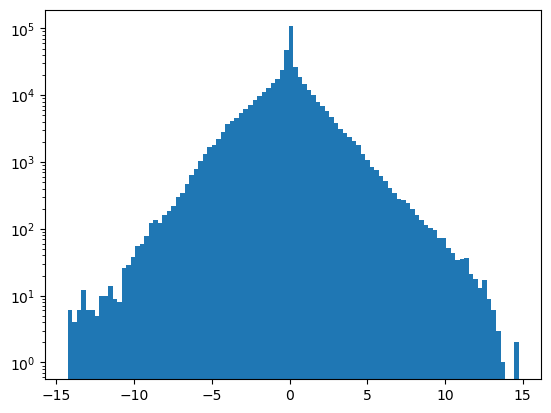

In [7]:
plt.hist(deltaT, bins=100)
plt.yscale('log')
plt.show()

In [8]:
theta = []
j = 0
for i in range(len(ds_flat)):
    if indices[0][i]:
        theta.append(to_pred[j])
        j += 1
    else:
        theta.append(np.nan)
te = np.array(theta).reshape((len(ds['z']),len(ds['y']),len(ds['x'])))

In [9]:
rdata = io.read_restart(expname, leg)
varlist = ['tn', 'tb']
for var in varlist:
    rdata[var] = xr.where(rdata[var]!=0.0, te, 0.0)

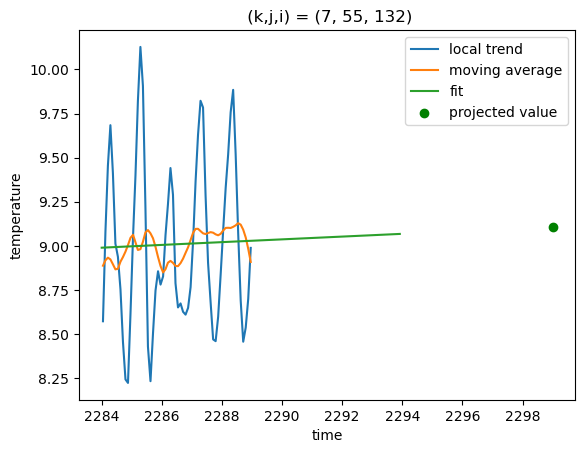

In [10]:
check_fit=True
if check_fit:
    i=random.randint(0, to_wonan.shape[1]-1)
    kji = osm.flatten_to_triad(i, 31, 148, 180)
    model = LinearRegression()
    x_row = np.array(x).reshape(len(x),-1)
    y_row = to_wonan[:,i].reshape(len(x),-1)
    model.fit(x_row, y_row)
    mp = model.coef_[0][0]
    qp = model.intercept_[0]
    yf = model.predict([[xf]])
    if yf < -1.8:
        yf = y_row[-1]
    ym = osm.movave(y_row.flatten(),12).reshape(len(x),-1)
    yp = []; xp = []
    for i in range(len(x)*2):
        xp.append(startyear+i/12.)
        yp.append(mp*(startyear+i/12.)+qp)    
    plt.plot(x_row,y_row)
    plt.plot(x,ym)
    plt.plot(xp,yp)
    plt.scatter(xf,yf, color='green')
    plt.ylabel('temperature')
    plt.xlabel('time')
    plt.title('')
    plt.title(' (k,j,i) = {}'.format(kji))
    plt.gca().legend(('local trend','moving average','fit','projected value'))
    plt.savefig('check.png')

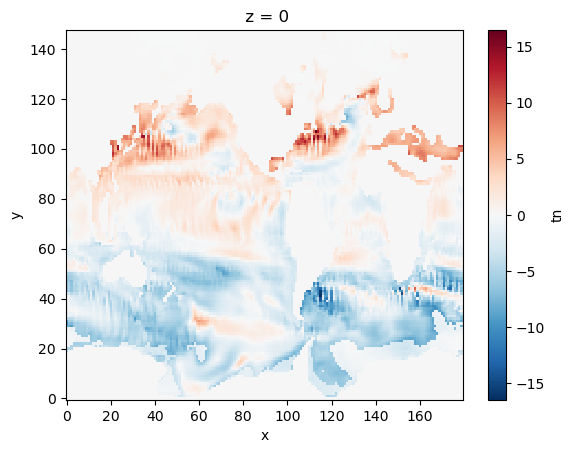

In [11]:
check_map=True
if check_map:
    rdata0 = io.read_restart(expname, leg)
    dd = xr.where(rdata0['tn']!=0, rdata['tn'].values-rdata0['tn'].values, 0.0)
    #fig = plt.figure(figsize=(1,1), dpi=300)
    #ax = fig.add_subplot(111)
    zlev=0
    dd.isel(time_counter=0,nav_lev=zlev).plot()
    plt.title(' z = {}'.format(zlev))
    #fig.savefig('check_map.png', bbox_inches='tight')

In [12]:
df = osm.elements(expname='lfr0')  
xdata = io.read_T(expname='lfr0', year=xf)
mdata = xdata['to'].mean('time')
ndata = xr.where(mdata!=0.0, te, 0.0)
delta2 = xr.where(mdata!=0.0, pow(ndata.values-mdata.values,2), 0.0)
err = delta2.weighted(df['vol']).mean(dim=['z', 'y', 'x']).values
err[0]

3.288832585365916

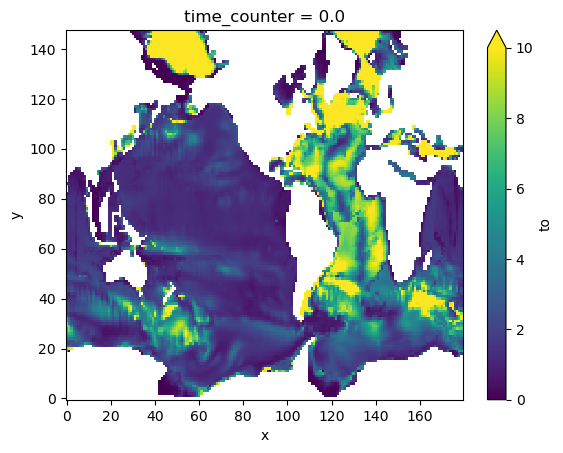

In [13]:
delta2.weighted(df['dz']).mean(dim='z').plot(vmin=0,vmax=10)